In [1]:
import numpy as np
import tensorflow as tf
import sys
import json
import math
from math import ceil
import matplotlib.pyplot as plt
import os
import csv
import cv2
import sklearn
import glob
import itertools
from datetime import datetime
#import matplotlib as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
tf.__version__

'1.15.0'

In [3]:
cv2.__version__

'4.2.0'

### data_utils

In [4]:
def hu_to_uint8(hu_images, window_width, window_center):
    """Converts HU images to uint8 images"""
    images = (hu_images.astype(np.float) - window_center + window_width/2)/window_width
    uint8_images = np.uint8(255.0*np.clip(images, 0.0, 1.0))
    return uint8_images

In [5]:
def ensure_uint8(data, window_width=1500, window_center=-600):
    """Converts non-uint8 data to uint8 and applies window level to HU data"""
    if data.dtype != np.uint8:
        if data.ptp() > 255:
            # Assume HU
            data = hu_to_uint8(data, window_width, window_center)
        data = data.astype(np.uint8)
    return data

In [6]:
def find_contours(binary_image):
    """Helper function for finding contours"""
    return cv2.findContours(binary_image, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)[0]

In [7]:
def body_contour(binary_image):
    """Helper function to get body contour"""
    contours = find_contours(binary_image)
    areas = [cv2.contourArea(cnt) for cnt in contours]
    body_idx = np.argmax(areas)
    return contours[body_idx]

In [8]:
def auto_body_crop(image, scale=1.0):
    """Roughly crop an image to the body region"""
    # Create initial binary image
    filt_image = cv2.GaussianBlur(image, (5, 5), 0)
    thresh = cv2.threshold(filt_image[filt_image > 0], 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[0]
    bin_image = np.uint8(filt_image > thresh)
    erode_kernel = np.ones((7, 7), dtype=np.uint8)
    bin_image = cv2.erode(bin_image, erode_kernel)

    # Find body contour
    body_cont = body_contour(bin_image).squeeze()

    # Get bbox
    xmin = body_cont[:, 0].min()
    xmax = body_cont[:, 0].max() + 1
    ymin = body_cont[:, 1].min()
    ymax = body_cont[:, 1].max() + 1

    # Scale to final bbox
    if scale > 0 and scale != 1.0:
        center = ((xmax + xmin)/2, (ymin + ymax)/2)
        width = scale*(xmax - xmin + 1)
        height = scale*(ymax - ymin + 1)
        xmin = int(center[0] - width/2)
        xmax = int(center[0] + width/2)
        ymin = int(center[1] - height/2)
        ymax = int(center[1] + height/2)

    return image[ymin:ymax, xmin:xmax], (xmin, ymin, xmax, ymax)

In [9]:
def multi_ext_file_iter(directory, extensions):
    """Creates a multi-extension file iterator"""
    patterns = ['*.' + ext.lower() for ext in extensions]
    return itertools.chain.from_iterable(
        glob.iglob(os.path.join(directory, pat)) for pat in patterns)

### Prepare_data

In [10]:
IMG_EXTENSIONS = ('png', 'jpg', 'jpeg', 'tif')
CLASS_MAP = {'Normal': 0, 'CP': 1, 'NCP': 2}

In [11]:
def get_lesion_files(lesion_file, exclude_list, root_dir):
    """Reads the lesion file to identify relevant
    slices and returns their paths"""
    files = []
    with open(lesion_file, 'r') as f:
        f.readline()
        for line in f.readlines():
            cls, pid = line.split('/')[:2]
            if pid not in exclude_list:
                files.append(os.path.join(root_dir, line.strip('\n'))) ###*********###
    return files

In [12]:
def get_files(lesion_file, unzip_file, exclude_file, root_dir):
    """Gets image file paths according to given lists"""
    excluded_pids = get_excluded_pids(exclude_file)
    files = get_lesion_files(lesion_file, excluded_pids['CP'] + excluded_pids['NCP'], root_dir)
    with open(unzip_file, 'r') as f:
        reader = list(csv.DictReader(f, delimiter=',', quotechar='|'))
        for row in reader:
            if row['label'] == 'Normal':
                pid = row['patient_id']
                sid = row['scan_id']
                if pid not in excluded_pids['Normal']:
                    files += get_source_paths(root_dir, 'Normal', pid, sid)
    return files

In [13]:
def get_source_paths(root_dir, cls, pid, sid):
    """Helper function to construct source paths"""
    exam_dir = os.path.join(root_dir, cls, pid, sid)
    return list(multi_ext_file_iter(exam_dir, IMG_EXTENSIONS))

In [14]:
def make_output_path(output_dir, source_path):
    """Helper function to construct output paths"""
    source_path = source_path.replace('\\', '/')
    parts = source_path.split('/')[-4:]
    output_path = os.path.join(output_dir, '_'.join(parts))
    output_path = os.path.splitext(output_path)[0] + '.png'
    return output_path

In [15]:
def imread_gray(path):
    """Reads images in grayscale"""
    image = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    if image.ndim > 2:
        image = image[:, :, 0]
    return image

In [16]:
def get_excluded_pids(exclude_file):
    """Reads the exclusion list and returns a
    dict of lists of excluded patients"""
    exclude_pids = {
        'NCP': [],
        'CP': [],
        'Normal': []
    }
    with open(exclude_file, 'r') as f:
        for line in f.readlines():
            cls, pid = line.strip('\n').split()
            exclude_pids[cls].append(pid)
    return exclude_pids

In [17]:
root_dir = 'C:/Users/sonal/OneDrive/Desktop/Covid19_project/CovidNet/COVIDNet-CT-master'
output_dir = 'C:/Users/sonal/OneDrive/Desktop/Covid19_project/CovidNet/COVIDNet-CT-master/output'
lesion_file = 'C:/Users/sonal/OneDrive/Desktop/Covid19_project/CovidNet/COVIDNet-CT-master/lesions_slices.csv'
unzip_file = 'C:/Users/sonal/OneDrive/Desktop/Covid19_project/CovidNet/COVIDNet-CT-master/unzip_filenames.csv'
exclude_file = 'C:/Users/sonal/OneDrive/Desktop/Covid19_project/CovidNet/COVIDNet-CT-master/exclude_list.txt'
image_files = get_files(lesion_file, unzip_file, exclude_file, root_dir)

In [18]:
# Write to new files as PNGs
for imf in image_files:
    image = imread_gray(imf)
    output_path = make_output_path(output_dir, imf)
    cv2.imwrite(output_path, image)

### Augmentations

In [19]:
def random_rotation(image, max_degrees, bbox=None, prob=0.5):
    """Applies random rotation to image and bbox"""
    def _rotation(image, bbox):
        # Get random angle
        degrees = tf.random.uniform([], minval=-max_degrees, maxval=max_degrees, dtype=tf.float32)
        radians = degrees * math.pi / 180.
        if bbox is not None:
            # Get offset from image center
            image_shape = tf.cast(tf.shape(image), tf.float32)
            image_height, image_width = image_shape[0], image_shape[1]
            bbox = tf.cast(bbox, tf.float32)
            center_x = image_width / 2.
            center_y = image_height / 2.
            bbox_center_x = (bbox[0] + bbox[2]) / 2.
            bbox_center_y = (bbox[1] + bbox[3]) / 2.
            trans_x = center_x - bbox_center_x
            trans_y = center_y - bbox_center_y

            # Apply rotation
            image = _translate_image(image, trans_x, trans_y)
            bbox = _translate_bbox(bbox, image_height, image_width, trans_x, trans_y)
            image = tf.contrib.image.rotate(image, radians, interpolation='BILINEAR')
            bbox = _rotate_bbox(bbox, image_height, image_width, radians)
            image = _translate_image(image, -trans_x, -trans_y)
            bbox = _translate_bbox(bbox, image_height, image_width, -trans_x, -trans_y)
            bbox = tf.cast(bbox, tf.int32)

            return image, bbox
        return tf.contrib.image.rotate(image, radians, interpolation='BILINEAR')

    retval = image if bbox is None else (image, bbox)
    return tf.cond(_should_apply(prob), lambda: _rotation(image, bbox), lambda: retval)

In [20]:
def random_bbox_jitter(bbox, image_height, image_width, max_fraction, prob=0.5):
    """Jitters bbox coordinates by +/- jitter_fraction of the width/height"""
    def _bbox_jitter(bbox):
        bbox = tf.cast(bbox, tf.float32)
        width_jitter = max_fraction*(bbox[2] - bbox[0])
        height_jitter = max_fraction*(bbox[3] - bbox[1])
        xmin = bbox[0] + tf.random.uniform([], minval=-width_jitter, maxval=width_jitter, dtype=tf.float32)
        ymin = bbox[1] + tf.random.uniform([], minval=-height_jitter, maxval=height_jitter, dtype=tf.float32)
        xmax = bbox[2] + tf.random.uniform([], minval=-width_jitter, maxval=width_jitter, dtype=tf.float32)
        ymax = bbox[3] + tf.random.uniform([], minval=-height_jitter, maxval=height_jitter, dtype=tf.float32)
        xmin, ymin, xmax, ymax = _clip_bbox(xmin, ymin, xmax, ymax, image_height, image_width)
        bbox = tf.cast(tf.stack([xmin, ymin, xmax, ymax]), tf.int32)
        return bbox

    return tf.cond(_should_apply(prob), lambda: _bbox_jitter(bbox), lambda: bbox)

In [21]:
def random_shift_and_scale(image, max_shift, max_scale_change, prob=0.5):
    """Applies random shift and scale to pixel values"""
    def _shift_and_scale(image):
        shift = tf.cast(tf.random.uniform([], minval=-max_shift, maxval=max_shift, dtype=tf.int32), tf.float32)
        scale = tf.random.uniform([], minval=(1. - max_scale_change),
                                  maxval=(1. + max_scale_change), dtype=tf.float32)
        image = scale*(tf.cast(image, tf.float32) + shift)
        image = tf.cast(tf.clip_by_value(image, 0., 255.), tf.uint8)
        return image

    return tf.cond(_should_apply(prob), lambda: _shift_and_scale(image), lambda: image)

In [22]:
def random_shear(image, max_lambda, bbox=None, prob=0.5):
    """Applies shear in either the x or y direction"""
    shear_lambda = tf.random.uniform([], minval=-max_lambda, maxval=max_lambda, dtype=tf.float32)
    image_shape = tf.cast(tf.shape(image), tf.float32)
    image_height, image_width = image_shape[0], image_shape[1]

    def _shear_x(image, bbox):
        image = _shear_x_image(image, shear_lambda)
        if bbox is not None:
            bbox = _shear_bbox(bbox, image_height, image_width, shear_lambda, horizontal=True)
            bbox = tf.cast(bbox, tf.int32)
            return image, bbox
        return image

    def _shear_y(image, bbox):
        image = _shear_y_image(image, shear_lambda)
        if bbox is not None:
            bbox = _shear_bbox(bbox, image_height, image_width, shear_lambda, horizontal=False)
            bbox = tf.cast(bbox, tf.int32)
            return image, bbox
        return image

    def _shear(image, bbox):
        return tf.cond(_should_apply(0.5), lambda: _shear_x(image, bbox), lambda: _shear_y(image, bbox))

    retval = image if bbox is None else (image, bbox)
    return tf.cond(_should_apply(prob), lambda: _shear(image, bbox), lambda: retval)

In [23]:
def _translate_image(image, delta_x, delta_y):
    """Translate an image"""
    return tf.contrib.image.translate(image, [delta_x, delta_y], interpolation='BILINEAR')

In [24]:
def _translate_bbox(bbox, image_height, image_width, delta_x, delta_y):
    """Translate an bbox, ensuring coordinates lie in the image"""
    bbox = bbox + tf.stack([delta_x, delta_y, delta_x, delta_y])
    xmin, ymin, xmax, ymax = _clip_bbox(bbox[0], bbox[1], bbox[2], bbox[3], image_height, image_width)
    bbox = tf.stack([xmin, ymin, xmax, ymax])
    return bbox

In [25]:
def _rotate_bbox(bbox, image_height, image_width, radians):
    """Rotates the bbox by the given angle"""
    # Shift bbox to origin
    xmin, ymin, xmax, ymax = bbox[0], bbox[1], bbox[2], bbox[3]
    center_x = (xmin + xmax) / 2.
    center_y = (ymin + ymax) / 2.
    xmin = xmin - center_x
    xmax = xmax - center_x
    ymin = ymin - center_y
    ymax = ymax - center_y

    # Rotate bbox coordinates
    radians = -radians  # negate direction since y-axis is flipped
    coords = tf.stack([[xmin, ymin], [xmax, ymin], [xmin, ymax], [xmax, ymax]])
    coords = tf.transpose(tf.cast(coords, tf.float32))
    rotation_matrix = tf.stack(
        [[tf.cos(radians), -tf.sin(radians)],
         [tf.sin(radians), tf.cos(radians)]])
    new_coords = tf.matmul(rotation_matrix, coords)

    # Find new bbox coordinates and clip to image size
    xmin = tf.reduce_min(new_coords[0, :]) + center_x
    ymin = tf.reduce_min(new_coords[1, :]) + center_y
    xmax = tf.reduce_max(new_coords[0, :]) + center_x
    ymax = tf.reduce_max(new_coords[1, :]) + center_y
    xmin, ymin, xmax, ymax = _clip_bbox(xmin, ymin, xmax, ymax, image_height, image_width)
    bbox = tf.stack([xmin, ymin, xmax, ymax])

    return bbox

In [26]:
def _shear_x_image(image, shear_lambda):
    """Shear image in x-direction"""
    tform = tf.stack([1., shear_lambda, 0., 0., 1., 0., 0., 0.])
    image = tf.contrib.image.transform(
        image, tform, interpolation='BILINEAR')
    return image

In [27]:
def _shear_y_image(image, shear_lambda):
    """Shear image in y-direction"""
    tform = tf.stack([1., 0., 0., shear_lambda, 1., 0., 0., 0.])
    image = tf.contrib.image.transform(
        image, tform, interpolation='BILINEAR')
    return image

In [28]:
def _shear_bbox(bbox, image_height, image_width, shear_lambda, horizontal=True):
    """Shear bbox in x- or y-direction"""
    # Shear bbox coordinates
    xmin, ymin, xmax, ymax = bbox[0], bbox[1], bbox[2], bbox[3]
    coords = tf.stack([[xmin, ymin], [xmax, ymin], [xmin, ymax], [xmax, ymax]])
    coords = tf.transpose(tf.cast(coords, tf.float32))
    if horizontal:
        shear_matrix = tf.stack(
            [[1., -shear_lambda],
             [0., 1.]])
    else:
        shear_matrix = tf.stack(
            [[1., 0.],
             [-shear_lambda, 1.]])
    new_coords = tf.matmul(shear_matrix, coords)

    # Find new bbox coordinates and clip to image size
    xmin = tf.reduce_min(new_coords[0, :])
    ymin = tf.reduce_min(new_coords[1, :])
    xmax = tf.reduce_max(new_coords[0, :])
    ymax = tf.reduce_max(new_coords[1, :])
    xmin, ymin, xmax, ymax = _clip_bbox(xmin, ymin, xmax, ymax, image_height, image_width)
    bbox = tf.stack([xmin, ymin, xmax, ymax])

    return bbox

In [29]:
def _clip_bbox(xmin, ymin, xmax, ymax, image_height, image_width):
    """Clip bbox to valid image coordinates"""
    xmin = tf.clip_by_value(xmin, 0, image_width)
    ymin = tf.clip_by_value(ymin, 0, image_height)
    xmax = tf.clip_by_value(xmax, 0, image_width)
    ymax = tf.clip_by_value(ymax, 0, image_height)
    return xmin, ymin, xmax, ymax

In [30]:
def _should_apply(prob):
    """Helper function to create bool tensor with probability"""
    return tf.cast(tf.floor(tf.random_uniform([], dtype=tf.float32) + prob), tf.bool)

### Dataset - COVIDxCTDataset

In [31]:
class COVIDxCTDataset:
    """COVIDx-CT dataset class, which handles construction of train/validation datasets"""
    def __init__(self, data_dir, image_height=512, image_width=512, max_bbox_jitter=0.025, max_rotation=10,
                 max_shear=0.15, max_pixel_shift=10, max_pixel_scale_change=0.2, shuffle_buffer=1000):
        # General parameters
        self.data_dir = data_dir
        self.image_height = image_height
        self.image_width = image_width
        self.shuffle_buffer = shuffle_buffer

        # Augmentation parameters
        self.max_bbox_jitter = max_bbox_jitter
        self.max_rotation = max_rotation
        self.max_shear = max_shear
        self.max_pixel_shift = max_pixel_shift
        self.max_pixel_scale_change = max_pixel_scale_change

    def train_dataset(self, train_split_file='train.txt', batch_size=1):
        """Returns training dataset"""
        return self._make_dataset(train_split_file, batch_size, True)

    def validation_dataset(self, val_split_file='val.txt', batch_size=1):
        """Returns validation dataset (also used for testing)"""
        return self._make_dataset(val_split_file, batch_size, False)

    def _make_dataset(self, split_file, batch_size, is_training, balanced=True):
        """Creates COVIDX-CT dataset for train or val split"""
        files, classes, bboxes = self._get_files(split_file)
        count = len(files)

        # Create balanced dataset if required
        if is_training and balanced:
            files = np.asarray(files)
            classes = np.asarray(classes, dtype=np.int32)
            bboxes = np.asarray(bboxes, dtype=np.int32)
            class_nums = np.unique(classes)
            class_wise_datasets = []
            for cls in class_nums:
                indices = np.where(classes == cls)[0]
                class_wise_datasets.append(
                    tf.data.Dataset.from_tensor_slices((files[indices], classes[indices], bboxes[indices])))
            class_weights = [1.0 / len(class_nums) for _ in class_nums]
            dataset = tf.data.experimental.sample_from_datasets(
                class_wise_datasets, class_weights)
        else:
            dataset = tf.data.Dataset.from_tensor_slices((files, classes, bboxes))

        # Shuffle and repeat in training
        if is_training:
            dataset = dataset.shuffle(buffer_size=self.shuffle_buffer)
            dataset = dataset.repeat()

        # Create and apply map function
        load_and_process = self._get_load_and_process_fn(is_training)
        dataset = dataset.map(load_and_process)

        # Batch data
        dataset = dataset.batch(batch_size)

        return dataset, count, batch_size

    def _get_load_and_process_fn(self, is_training):
        """Creates map function for TF dataset"""
        def load_and_process(path, label, bbox):
            # Load image
            image = tf.image.decode_png(tf.io.read_file(path), channels=1)

            # Apply augmentations and/or crop to bbox
            if is_training:
                image, bbox = self._augment_image_and_bbox(image, bbox)
            else:
                image = tf.image.crop_to_bounding_box(image, bbox[1], bbox[0], bbox[3] - bbox[1], bbox[2] - bbox[0])

            # Stack to 3-channel, scale to [0, 1] and resize
            image = tf.image.grayscale_to_rgb(image)
            image = tf.cast(image, tf.float32)
            image = image / 255.0
            image = tf.image.resize(image, [self.image_height, self.image_width])
            label = tf.cast(label, dtype=tf.int32)

            return {'image': image, 'label': label}

        return load_and_process

    def _augment_image_and_bbox(self, image, bbox):
        """Apply augmentations to image and bbox"""
        image_shape = tf.cast(tf.shape(image), tf.float32)
        image_height, image_width = image_shape[0], image_shape[1]
        bbox = random_bbox_jitter(bbox, image_height, image_width, self.max_bbox_jitter)
        image, bbox = random_rotation(image, self.max_rotation, bbox)
        image, bbox = random_shear(image, self.max_shear, bbox)
        image = tf.image.crop_to_bounding_box(image, bbox[1], bbox[0], bbox[3] - bbox[1], bbox[2] - bbox[0])
        image = random_shift_and_scale(image, self.max_pixel_shift, self.max_pixel_scale_change)
        image = tf.image.random_flip_left_right(image)
        return image, bbox

    def _get_files(self, split_file):
        """Gets image filenames and classes"""
        files, classes, bboxes = [], [], []
        with open(split_file, 'r') as f:
            for line in f.readlines():
                fname, cls, xmin, ymin, xmax, ymax = line.strip('\n').split()
                files.append(os.path.join(self.data_dir, fname))
                classes.append(int(cls))
                bboxes.append([int(xmin), int(ymin), int(xmax), int(ymax)])
        return files, classes, bboxes


### run_covidnet_ct

In [32]:
slim = tf.contrib.slim

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [33]:
# Dict keys
TRAIN_OP_KEY = 'train_op'
TF_SUMMARY_KEY = 'tf_summaries'
LOSS_KEY = 'loss'

# Tensor names
IMAGE_INPUT_TENSOR = 'Placeholder:0'
LABEL_INPUT_TENSOR = 'Placeholder_1:0'
CLASS_PRED_TENSOR = 'ArgMax:0'
CLASS_PROB_TENSOR = 'softmax_tensor:0'
TRAINING_PH_TENSOR = 'is_training:0'
LOSS_TENSOR = 'add:0'

# Names for train checkpoints
CKPT_NAME = 'model.ckpt'
MODEL_NAME = 'COVIDNet-CT'
'output'
# Output directory for storing runs
OUTPUT_DIR = 'output'

# Class names ordered by class index
CLASS_NAMES = ('Normal', 'Pneumonia', 'COVID-19')

In [34]:
def dense_grad_filter(gvs):
    """Filter to apply gradient updates to dense layers only"""
    return [(g, v) for g, v in gvs if 'dense' in v.name]

In [35]:
def simple_summary(tag_to_value, tag_prefix=''):
    """Summary object for a dict of python scalars"""
    return tf.Summary(value=[tf.Summary.Value(tag=tag_prefix + tag, simple_value=value)
                             for tag, value in tag_to_value.items() if isinstance(value, (int, float))])

In [36]:
def create_session():
    """Helper function for session creation"""
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    sess = tf.Session(config=config)
    return sess

In [37]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
class Metrics:
    """Lightweight class for tracking metrics"""
    def __init__(self):
        num_classes = len(CLASS_NAMES)
        self.labels = list(range(num_classes))
        self.class_names = CLASS_NAMES
        self.confusion_matrix = np.zeros((num_classes, num_classes), dtype=np.uint32)

    def update(self, y_true, y_pred):
        self.confusion_matrix = self.confusion_matrix + confusion_matrix(y_true, y_pred, labels=self.labels)

    def reset(self):
        self.confusion_matrix *= 0

    def values(self):
        conf_matrix = self.confusion_matrix.astype('float')
        metrics = {
            'accuracy': np.diag(conf_matrix).sum() / conf_matrix.sum(),
            'confusion matrix': self.confusion_matrix.copy()
        }
        sensitivity = np.diag(conf_matrix) / np.maximum(conf_matrix.sum(axis=1), 1)
        pos_pred_val = np.diag(conf_matrix) / np.maximum(conf_matrix.sum(axis=0), 1)
        for cls, idx, sens, ppv in zip(self.class_names, self.labels, sensitivity, pos_pred_val):
            metrics['{} {}'.format(cls, 'sensitivity')] = sensitivity[idx]
            metrics['{} {}'.format(cls, 'PPV')] = pos_pred_val[idx]
        return metrics

In [38]:
class COVIDNetCTRunner:
    """Primary training/testing/inference class"""
    def __init__(self, meta_file, ckpt=None, data_dir=None, input_height=224, input_width=224, max_bbox_jitter=0.025,
                 max_rotation=10, max_shear=0.15, max_pixel_shift=10, max_pixel_scale_change=0.2):
        self.meta_file = meta_file
        self.ckpt = ckpt
        self.input_height = input_height
        self.input_width = input_width
        if data_dir is None:
            self.dataset = None
        else:
            self.dataset = COVIDxCTDataset(
                data_dir,
                image_height=input_height,
                image_width=input_width,
                max_bbox_jitter=max_bbox_jitter,
                max_rotation=max_rotation,
                max_shear=max_shear,
                max_pixel_shift=max_pixel_shift,
                max_pixel_scale_change=max_pixel_scale_change
            )

    def load_graph(self):
        """Creates new graph and session"""
        graph = tf.Graph()
        with graph.as_default():
            # Create session and load model
            sess = create_session()

            # Load meta file
            print('Loading meta graph from ' + self.meta_file)
            saver = tf.train.import_meta_graph(self.meta_file)
        return graph, sess, saver

    def load_ckpt(self, sess, saver):
        """Helper for loading weights"""
        # Load weights
        if self.ckpt is not None:
            print('Loading weights from ' + self.ckpt)
            saver.restore(sess, self.ckpt)

    def trainval(self, epochs, output_dir, batch_size=1, learning_rate=0.001, momentum=0.9,
                 fc_only=False, train_split_file='train.txt', val_split_file='val.txt',
                 log_interval=20, val_interval=1000, save_interval=1000):
        """Run training with intermittent validation"""
        ckpt_path = os.path.join(output_dir, CKPT_NAME)
        graph, sess, saver = self.load_graph()
        with graph.as_default():
            # Create optimizer
            optimizer = tf.train.MomentumOptimizer(
                learning_rate=learning_rate,
                momentum=momentum
            )

            # Create train op
            global_step = tf.train.get_or_create_global_step()
            loss = graph.get_tensor_by_name(LOSS_TENSOR)
            grad_vars = optimizer.compute_gradients(loss)
            if fc_only:
                grad_vars = dense_grad_filter(grad_vars)
            minimize_op = optimizer.apply_gradients(grad_vars, global_step)
            update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
            train_op = tf.group(minimize_op, update_ops)

            # Load checkpoint
            sess.run(tf.global_variables_initializer())
            self.load_ckpt(sess, saver)

            # Create train dataset
            dataset, num_images, batch_size = self.dataset.train_dataset(train_split_file, batch_size)
            data_next = dataset.make_one_shot_iterator().get_next()
            num_iters = ceil(num_images / batch_size) * epochs

            # Create feed and fetch dicts
            feed_dict = {TRAINING_PH_TENSOR: True}
            fetch_dict = {
                TRAIN_OP_KEY: train_op,
                LOSS_KEY: LOSS_TENSOR
            }

            # Add summaries
            summary_writer = tf.summary.FileWriter(os.path.join(output_dir, 'events'), graph)
            fetch_dict[TF_SUMMARY_KEY] = self._get_train_summary_op(graph)

            # Create validation function
            run_validation = self._get_validation_fn(sess, batch_size, val_split_file)

            # Baseline saving and validation
            print('Saving baseline checkpoint')
            saver = tf.train.Saver()
            saver.save(sess, ckpt_path, global_step=0)
            print('Starting baseline validation')
            metrics = run_validation()
            self._log_and_print_metrics(metrics, 0, summary_writer)

            # Training loop
            print('Training with batch_size {} for {} steps'.format(batch_size, num_iters))
            for i in range(num_iters):
                # Run training step
                data = sess.run(data_next)
                feed_dict[IMAGE_INPUT_TENSOR] = data['image']
                feed_dict[LABEL_INPUT_TENSOR] = data['label']
                results = sess.run(fetch_dict, feed_dict)

                # Log and save
                step = i + 1
                if step % log_interval == 0:
                    summary_writer.add_summary(results[TF_SUMMARY_KEY], step)
                    print('[step: {}, loss: {}]'.format(step, results[LOSS_KEY]))
                if step % save_interval == 0:
                    print('Saving checkpoint at step {}'.format(step))
                    saver.save(sess, ckpt_path, global_step=step)
                if val_interval > 0 and step % val_interval == 0:
                    print('Starting validation at step {}'.format(step))
                    metrics = run_validation()
                    self._log_and_print_metrics(metrics, step, summary_writer)

            print('Saving checkpoint at last step')
            saver.save(sess, ckpt_path, global_step=num_iters)

    def test(self, batch_size=1, test_split_file='test.txt', plot_confusion=False):
        """Run test on a checkpoint"""
        graph, sess, saver = self.load_graph()
        with graph.as_default():
            # Load checkpoint
            self.load_ckpt(sess, saver)

            # Run test
            print('Starting test')
            metrics = self._get_validation_fn(sess, batch_size, test_split_file)()
            self._log_and_print_metrics(metrics)

            if plot_confusion:
                # Plot confusion matrix
                fig, ax = plt.subplots()
                disp = ConfusionMatrixDisplay(confusion_matrix=metrics['confusion matrix'],
                                              display_labels=CLASS_NAMES)
                disp.plot(include_values=True, cmap='Blues', ax=ax, xticks_rotation='horizontal', values_format='.5g')
                plt.show()

    def infer(self, image_file, autocrop=False):
        """Run inference on the given image"""
        # Load and preprocess image
        image = cv2.imread(image_file, cv2.IMREAD_GRAYSCALE)
        if autocrop:
            image, _ = auto_body_crop(image)
        image = cv2.resize(image, (self.input_width, self.input_height), cv2.INTER_CUBIC)
        image = image.astype(np.float32) / 255.0
        image = np.expand_dims(np.stack((image, image, image), axis=-1), axis=0)

        # Create feed dict
        feed_dict = {IMAGE_INPUT_TENSOR: image, TRAINING_PH_TENSOR: False}

        # Run inference
        graph, sess, saver = self.load_graph()
        with graph.as_default():
            # Load checkpoint
            self.load_ckpt(sess, saver)

            # Run image through model
            class_, probs = sess.run([CLASS_PRED_TENSOR, CLASS_PROB_TENSOR], feed_dict=feed_dict)
            print('\nPredicted Class: ' + CLASS_NAMES[class_[0]])
            print('Confidences:' + ', '.join(
                '{}: {}'.format(name, conf) for name, conf in zip(CLASS_NAMES, probs[0])))
            print('**DISCLAIMER**')
            print('Do not use this prediction for self-diagnosis. '
                  'You should check with your local authorities for '
                  'the latest advice on seeking medical assistance.')

    def _get_validation_fn(self, sess, batch_size=1, val_split_file='val.txt'):
        """Creates validation function to call in self.trainval() or self.test()"""
        # Create val dataset
        dataset, num_images, batch_size = self.dataset.validation_dataset(val_split_file, batch_size)
        dataset = dataset.repeat()  # repeat so there is no need to reconstruct it
        data_next = dataset.make_one_shot_iterator().get_next()
        num_iters = ceil(num_images / batch_size)

        # Create running accuracy metric
        metrics = Metrics()

        # Create feed and fetch dicts
        fetch_dict = {'classes': CLASS_PRED_TENSOR}
        feed_dict = {TRAINING_PH_TENSOR: False}

        def run_validation():
            metrics.reset()
            for i in range(num_iters):
                data = sess.run(data_next)
                feed_dict[IMAGE_INPUT_TENSOR] = data['image']
                results = sess.run(fetch_dict, feed_dict)
                metrics.update(data['label'], results['classes'])
            return metrics.values()

        return run_validation

    @staticmethod
    def _log_and_print_metrics(metrics, step=None, summary_writer=None, tag_prefix='val/'):
        """Helper for logging and printing"""
        # Pop temporarily and print
        cm = metrics.pop('confusion matrix')
        print('\tconfusion matrix:')
        print('\t' + str(cm).replace('\n', '\n\t'))

        # Print scalar metrics
        for name, val in sorted(metrics.items()):
            print('\t{}: {}'.format(name, val))

        # Log scalar metrics
        if summary_writer is not None:
            summary = simple_summary(metrics, tag_prefix)
            summary_writer.add_summary(summary, step)

        # Restore confusion matrix
        metrics['confusion matrix'] = cm

    @staticmethod
    def _get_train_summary_op(graph, tag_prefix='train/'):
        loss = graph.get_tensor_by_name(LOSS_TENSOR)
        loss_summary = tf.summary.scalar(tag_prefix + 'loss', loss)
        return loss_summary


In [39]:
# Suppress most console output
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [40]:
mode = 'train'

In [41]:
# mode = 'train' 

# Create full paths
model_dir = 'models/COVIDNet-CT-A'
meta_file = 'models/COVIDNet-CT-A/model.meta'
ckpt = 'models/COVIDNet-CT-A/model'
input_height = 512
input_width = 512

# Create runner
if mode == 'train':
    augmentation_kwargs = dict(
        max_bbox_jitter = 0.075,
        max_rotation = 15,
        max_shear = 0.2,
        max_pixel_shift = 15,
        max_pixel_scale_change = 0.15
    )
else:
    augmentation_kwargs = {}
        
runner = COVIDNetCTRunner(
    meta_file,
    ckpt = ckpt,
    data_dir = 'data/COVIDx-CT',
    input_height = input_height,
    input_width = input_width,
    max_bbox_jitter = 0.075,
    max_rotation = 15,
    max_shear = 0.2,
    max_pixel_shift = 15,
    max_pixel_scale_change = 0.15
)

if mode == 'train':
    output_suffix = datetime.now().strftime('_%Y-%m-%d_%H.%M.%S')
    # Create output_dir and save run settings
    output_dir = os.path.join(OUTPUT_DIR, MODEL_NAME + output_suffix)
    os.makedirs(output_dir, exist_ok=False)
    
    data_dir = 'data/COVIDx-CT'
    train_split_file = 'train_COVIDx-CT.txt'
    val_split_file = 'val_COVIDx-CT.txt'
    epochs = 20
    batch_size = 8
    learning_rate = 0.001
    momentum = 0.9
    fc_only = 'store_true'
    log_interval = 50
    val_interval = 2000
    save_interval = 2000
    
    args = {"model_dir": "models/COVIDNet-CT-A", "meta_name": "model.meta", "ckpt_name": "model", "input_height": 512, \
     "input_width": 512, "output_suffix": output_suffix, "data_dir": "data/COVIDx-CT", \
     "train_split_file": "train_COVIDx-CT.txt", "val_split_file": "val_COVIDx-CT.txt", "epochs": 20, "batch_size": 8,\
     "learning_rate": 0.001, "momentum": 0.9, "fc_only": fc_only, "log_interval": 50, "val_interval": 2000,\
     "save_interval": 2000, "max_bbox_jitter": 0.075, "max_rotation": 15, "max_shear": 0.2, \
     "max_pixel_shift": 15, "max_pixel_scale_change": 0.15}

    # Run trainval
    runner.trainval(
        epochs,
        output_dir,
        batch_size = batch_size,
        learning_rate = learning_rate,
        momentum = momentum,
        fc_only = fc_only,
        train_split_file = train_split_file,
        val_split_file = val_split_file,
        log_interval = log_interval,
        val_interval = val_interval,
        save_interval = save_interval
    )
elif mode == 'test':
    data_dir = 'data/COVIDx-CT'
    batch_size = 8
    test_split_file = 'test_COVIDx-CT.txt'
    plot_confusion = 'store_true'
    
    # Run validation
    runner.test(
        batch_size = batch_size,
        test_split_file = test_split_file,
        plot_confusion = plot_confusion
    )
elif mode == 'infer':
    image_file = 'assets/ex-covid-ct.png'
    auto_crop = 'store_true'
    # Run inference
    runner.infer(image_file, auto_crop)

Loading meta graph from models/COVIDNet-CT-A/model.meta
Loading weights from models/COVIDNet-CT-A/model
Saving baseline checkpoint
Starting baseline validation
	confusion matrix:
	[[806   0   0]
	 [  0  49   0]
	 [  0   1  82]]
	COVID-19 PPV: 1.0
	COVID-19 sensitivity: 0.9879518072289156
	Normal PPV: 1.0
	Normal sensitivity: 1.0
	Pneumonia PPV: 0.98
	Pneumonia sensitivity: 1.0
	accuracy: 0.9989339019189766
Training with batch_size 8 for 2880 steps
[step: 50, loss: 0.0192182045429945]
[step: 100, loss: 0.018801812082529068]
[step: 150, loss: 0.019199267029762268]
[step: 200, loss: 0.020560581237077713]
[step: 250, loss: 0.01901834085583687]
[step: 300, loss: 0.019248995929956436]
[step: 350, loss: 0.08504898846149445]
[step: 400, loss: 0.025765813887119293]
[step: 450, loss: 0.020487787202000618]
[step: 500, loss: 0.018680505454540253]
[step: 550, loss: 0.01867026276886463]
[step: 600, loss: 0.018871096894145012]
[step: 650, loss: 0.0192891713231802]
[step: 700, loss: 0.0187181849032640

In [42]:
mode = 'test'

Loading meta graph from models/COVIDNet-CT-A/model.meta
Loading weights from models/COVIDNet-CT-A/model
Starting test
	confusion matrix:
	[[148   0   0]
	 [  0  42   0]
	 [  0  20 110]]
	COVID-19 PPV: 1.0
	COVID-19 sensitivity: 0.8461538461538461
	Normal PPV: 1.0
	Normal sensitivity: 1.0
	Pneumonia PPV: 0.6774193548387096
	Pneumonia sensitivity: 1.0
	accuracy: 0.9375


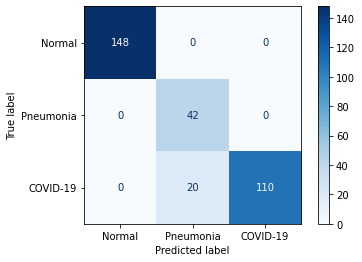

In [43]:
# mode = 'test' 

# Create full paths
model_dir = 'models/COVIDNet-CT-A'
meta_file = 'models/COVIDNet-CT-A/model.meta'
ckpt = 'models/COVIDNet-CT-A/model'
input_height = 512
input_width = 512

# Create runner
if mode == 'train':
    augmentation_kwargs = dict(
        max_bbox_jitter = 0.075,
        max_rotation = 15,
        max_shear = 0.2,
        max_pixel_shift = 15,
        max_pixel_scale_change = 0.15
    )
else:
    augmentation_kwargs = {}
        
runner = COVIDNetCTRunner(
    meta_file,
    ckpt = ckpt,
    data_dir = 'data/COVIDx-CT',
    input_height = input_height,
    input_width = input_width,
    max_bbox_jitter = 0.075,
    max_rotation = 15,
    max_shear = 0.2,
    max_pixel_shift = 15,
    max_pixel_scale_change = 0.15
)

if mode == 'train':
    output_suffix = datetime.now().strftime('_%Y-%m-%d_%H.%M.%S')
    # Create output_dir and save run settings
    output_dir = os.path.join(OUTPUT_DIR, MODEL_NAME + output_suffix)
    os.makedirs(output_dir, exist_ok=False)
    
    data_dir = 'data/COVIDx-CT'
    train_split_file = 'train_COVIDx-CT.txt'
    val_split_file = 'val_COVIDx-CT.txt'
    epochs = 20
    batch_size = 8
    learning_rate = 0.001
    momentum = 0.9
    fc_only = 'store_true'
    log_interval = 50
    val_interval = 2000
    save_interval = 2000
    
    args = {"model_dir": "models/COVIDNet-CT-A", "meta_name": "model.meta", "ckpt_name": "model", "input_height": 512, \
     "input_width": 512, "output_suffix": output_suffix, "data_dir": "data/COVIDx-CT", \
     "train_split_file": "train_COVIDx-CT.txt", "val_split_file": "val_COVIDx-CT.txt", "epochs": 20, "batch_size": 8,\
     "learning_rate": 0.001, "momentum": 0.9, "fc_only": fc_only, "log_interval": 50, "val_interval": 2000,\
     "save_interval": 2000, "max_bbox_jitter": 0.075, "max_rotation": 15, "max_shear": 0.2, \
     "max_pixel_shift": 15, "max_pixel_scale_change": 0.15}

    # Run trainval
    runner.trainval(
        epochs,
        output_dir,
        batch_size = batch_size,
        learning_rate = learning_rate,
        momentum = momentum,
        fc_only = fc_only,
        train_split_file = train_split_file,
        val_split_file = val_split_file,
        log_interval = log_interval,
        val_interval = val_interval,
        save_interval = save_interval
    )
elif mode == 'test':
    data_dir = 'data/COVIDx-CT'
    batch_size = 8
    test_split_file = 'test_COVIDx-CT.txt'
    plot_confusion = 'store_true'
    
    # Run validation
    runner.test(
        batch_size = batch_size,
        test_split_file = test_split_file,
        plot_confusion = plot_confusion
    )
elif mode == 'infer':
    image_file = 'assets/ex-covid-ct.png'
    auto_crop = 'store_true'
    # Run inference
    runner.infer(image_file, auto_crop)

In [44]:
mode = 'infer'

In [45]:
# mode = 'infer' 

# Create full paths
model_dir = 'models/COVIDNet-CT-A'
meta_file = 'models/COVIDNet-CT-A/model.meta'
ckpt = 'models/COVIDNet-CT-A/model'
input_height = 512
input_width = 512

# Create runner
if mode == 'train':
    augmentation_kwargs = dict(
        max_bbox_jitter = 0.075,
        max_rotation = 15,
        max_shear = 0.2,
        max_pixel_shift = 15,
        max_pixel_scale_change = 0.15
    )
else:
    augmentation_kwargs = {}
        
runner = COVIDNetCTRunner(
    meta_file,
    ckpt = ckpt,
    data_dir = 'data/COVIDx-CT',
    input_height = input_height,
    input_width = input_width,
    max_bbox_jitter = 0.075,
    max_rotation = 15,
    max_shear = 0.2,
    max_pixel_shift = 15,
    max_pixel_scale_change = 0.15
)

if mode == 'train':
    output_suffix = datetime.now().strftime('_%Y-%m-%d_%H.%M.%S')
    # Create output_dir and save run settings
    output_dir = os.path.join(OUTPUT_DIR, MODEL_NAME + output_suffix)
    os.makedirs(output_dir, exist_ok=False)
    
    data_dir = 'data/COVIDx-CT'
    train_split_file = 'train_COVIDx-CT.txt'
    val_split_file = 'val_COVIDx-CT.txt'
    epochs = 20
    batch_size = 8
    learning_rate = 0.001
    momentum = 0.9
    fc_only = 'store_true'
    log_interval = 50
    val_interval = 2000
    save_interval = 2000
    
    args = {"model_dir": "models/COVIDNet-CT-A", "meta_name": "model.meta", "ckpt_name": "model", "input_height": 512, \
     "input_width": 512, "output_suffix": output_suffix, "data_dir": "data/COVIDx-CT", \
     "train_split_file": "train_COVIDx-CT.txt", "val_split_file": "val_COVIDx-CT.txt", "epochs": 20, "batch_size": 8,\
     "learning_rate": 0.001, "momentum": 0.9, "fc_only": fc_only, "log_interval": 50, "val_interval": 2000,\
     "save_interval": 2000, "max_bbox_jitter": 0.075, "max_rotation": 15, "max_shear": 0.2, \
     "max_pixel_shift": 15, "max_pixel_scale_change": 0.15}

    # Run trainval
    runner.trainval(
        epochs,
        output_dir,
        batch_size = batch_size,
        learning_rate = learning_rate,
        momentum = momentum,
        fc_only = fc_only,
        train_split_file = train_split_file,
        val_split_file = val_split_file,
        log_interval = log_interval,
        val_interval = val_interval,
        save_interval = save_interval
    )
elif mode == 'test':
    data_dir = 'data/COVIDx-CT'
    batch_size = 8
    test_split_file = 'test_COVIDx-CT.txt'
    plot_confusion = 'store_true'
    
    # Run validation
    runner.test(
        batch_size = batch_size,
        test_split_file = test_split_file,
        plot_confusion = plot_confusion
    )
elif mode == 'infer':
    image_file = 'assets/ex-covid-ct.png'
    auto_crop = 'store_true'
    # Run inference
    runner.infer(image_file, auto_crop)

Loading meta graph from models/COVIDNet-CT-A/model.meta
Loading weights from models/COVIDNet-CT-A/model

Predicted Class: COVID-19
Confidences:Normal: 4.3196553178859176e-07, Pneumonia: 0.001139980275183916, COVID-19: 0.9988596439361572
**DISCLAIMER**
Do not use this prediction for self-diagnosis. You should check with your local authorities for the latest advice on seeking medical assistance.
